In [155]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import re
import requests 
import tensorflow as tf
import warnings

from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# About this notebook

This project focuses on answering the question if and how it would be possible to predict the future price of crypto currencies (focus on BTC).

3 LSTM models were created for this purpose:
- 1 regression model
- 2 classification models

Each model and it's inputs and outputs will be described further in the notebook.

*NOTE: To run this notebook correctly each cell should be executed in order and should not output any errors*

## Setting up data for all models 

In the next 2 cells the code downloads and scales **closing price data**, which is used as both the input and output during the training. 

Furthermore it also loads a dataset with aggregated daily sentiment on BTC from twitter (available [here](https://www.kaggle.com/datasets/rogerho/ssentiment-analysis-on-5yrs-of-tweets-about-btc)).

In [188]:
crypto_currency = "BTC"
against_currency = "USD"

sentiment_df = pd.read_csv("sentiment_data_consolidated.csv")
sentiment = sentiment_df["sentiment"]

start = dt.datetime.strptime(sentiment_df["time"].iloc[0], "%Y-%m-%d")
end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", start, end)

In [189]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(raw_data["Close"].values.reshape(-1,1))

## First model

This is a regressive model which tries to predict the price directly. It takes as an input a moving window of 60 days worth of prices and sentiment and outputs a week worth of predictions on prices (values can be adjusted in variables 	`training_days` and `predict_days`). 

First data needs to be formatted correctly for training which is done in the next cell. 

In [190]:
training_days = 60
predict_days = 7

X_train, y_train = [], []

for x in range(training_days, len(scaled_data) - predict_days - 140):
    X_train.append(scaled_data[x - training_days:x, 0])
    y_train.append(scaled_data[x:x+predict_days, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(training_days, len(scaled_data) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))

X_train = np.array(X_train)

In [ ]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2))
model.add(LSTM(units=128, dropout = 0.2))
model.add(Dense(units=7))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=['acc'])

with tf.device('/cpu:0'):
    model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[EarlyStopping(monitor='loss',patience=10)])

Create data for testing

In [194]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

X_test, y_test = [], []

for x in range(training_days, len(model_inputs)):
    X_test.append(model_inputs[x - training_days:x, 0])
    y_test.append(model_inputs[x:x+predict_days, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

X_test = np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs))):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_test = np.array(X_test)

The model performs seemingly ok, however after closer inspection of the graph it is apparent that this approach is very naïve as it always slacks around 7 days behind on its predictions, meaning that it basically doesn't do anything valuable and thus this approach was scrapped.

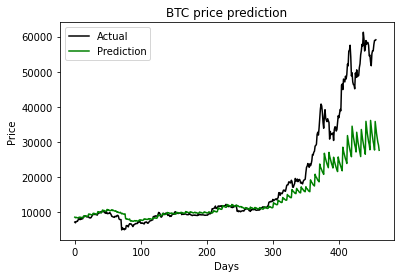

In [195]:
y_pred = []
for week in range(0, X_test.shape[0], 7):
    y_pred.append(model.predict(np.expand_dims(X_test[week], 0)))

y_pred = np.array(y_pred)
y_pred = np.expand_dims(y_pred.flatten(), 0)
actual_prices = raw_test_data["Close"].values
prediction_prices = scaler.inverse_transform(y_pred)[0]

plt.plot(actual_prices, color="black", label="Actual")
plt.plot(prediction_prices, color="green", label="Prediction")

plt.title(f"{crypto_currency} price prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

## Setting up data for second and third model

Here we scrape web for data on the volume of tweets and create another feature for training.

In [197]:
url = 'https://bitinfocharts.com/comparison/tweets-btc-dcr.html#alltime'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

scripts = soup.find_all('script')

for script in scripts:
    if 'd = new Dygraph(document.getElementById("container")' in script.text:
        StrList = script.text
        StrList = StrList.split('[[')[-1]
        StrList = StrList.split(']]')[0]
        StrList = StrList.replace("new Date(", '').replace(')','')
        clean = re.sub("[\[\]\s]","",StrList)
        splitted = re.split("[\'\"',]",clean)
        splitted = [l for l in splitted if len(l)!=0]
        del splitted[3-1::3]
        dataList = [s.replace("null", "") for s in splitted if s != '']
        dataList[1::2] = [int(v) if v != '' else 0 for v in dataList[1::2]]

In [198]:
date = []
tweet = []

for each in dataList:
    if (dataList.index(each) % 2) == 0:
        date.append(each)
    else:
        tweet.append(each)

df = pd.DataFrame(list(zip(date, tweet)), columns=["Date","Volume"])


Inputing missing data

In [199]:
volume = df[632:2550]["Volume"].values.astype(int)
to_impute = np.where(volume == 0)

avg_1 = (volume[539] + volume[558]) / 2
avg_2 = (volume[791] + volume[827]) / 2
avg_3 = (volume[1069] + volume[1071]) / 2
avg_4 = (volume[1659] + volume[1661]) / 2

for val in to_impute[0]:
    if val < 558:
        volume[val] = avg_1
    elif val < 827:
        volume[val] = avg_2
    elif val < 1071:
        volume[val] = avg_3
    else:
        volume[val] = avg_4
        
scaled_volume = scaler.fit_transform(volume.reshape(-1,1))

# Second model

The second model outputs 4 variables:
- small increase in price
- big increase in price
- small decrease in price
- big increase in price

The model tries to classify from 60 training days, what the price change will be for the upcoming week. The price change is calculated as a weighted average of all seven days and classified into one of the buckets as seen in the next cell.

The 2 upcoming cells create training and testing data for this model.

In [200]:
weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_train = [], [], []

for x in range(training_days, len(volume) - predict_days - 140):
    mean.append(np.average(scaled_data[x:x+predict_days, 0], weights=weights) - scaled_data[x-1])
    X_train.append(scaled_data[x - training_days:x, 0])

X_train= np.array(X_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_train)
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_train = np.array(X_train)

big_inc = 0
small_inc = 0
small_dec = 0
big_dec = 0

y_train = []

for i, val in enumerate(mean):
    if val > 0.01:
        big_inc += 1
        y_train.append(0)
    elif val > 0:
        small_inc += 1
        y_train.append(1)
    elif val < -0.01:
        big_dec += 1
        y_train.append(3)
    else:
        small_dec += 1
        y_train.append(2)
    
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

In [201]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_test = [], [], []

for x in range(training_days, len(model_inputs) - predict_days):
    mean.append(np.average(model_inputs[x:x+predict_days, 0], weights=weights) - model_inputs[x-1])
    X_test.append(model_inputs[x - training_days:x, 0])

X_test= np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_test)
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_test = np.array(X_test)

big_inc = 0
small_inc = 0
small_dec = 0
big_dec = 0

y_test = []

for i, val in enumerate(mean):
    if val > 0.01:
        big_inc += 1
        y_test.append(0)
    elif val > 0:
        small_inc += 1
        y_test.append(1)
    elif val < -0.01:
        big_dec += 1
        y_test.append(3)
    else:
        small_dec += 1
        y_test.append(2)
    
y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

## About second model and motivation for the third

For the classification models anything slightly above 50% accuracy on testing set would be considered a success as hypothetically that would (over a long period of time) mean steady profits.

Because the second model performed relatively poorly in both training and testing a third one was designed.

In [ ]:
dropout = 0.1
rec_dropout = 0.4

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=128, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(Dense(units=4, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])


history = model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[EarlyStopping(monitor='loss',patience=10)])

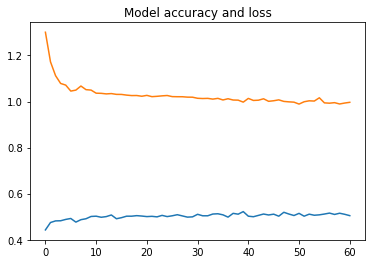

In [209]:
plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
plt.title('Model accuracy and loss')
plt.show()

In [210]:
results = model.evaluate(X_train, y_train, batch_size=256)
print("train loss, train acc:", results)

results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

7/7 [==============================] - 1s 41ms/step - loss: 0.9806 - acc: 0.5172
train loss, train acc: [0.9806298613548279, 0.517241358757019]
2/2 [==============================] - 0s 42ms/step - loss: 1.2360 - acc: 0.4511
test loss, test acc: [1.2360148429870605, 0.4511111080646515]


# Third model

Having only 2 classes (increase or decrease in price) would hopefully result in easier classification and better performance however also bring some problems (false positives/negatives, possibility for the model to only learn to select one of the outputs, etc.).

In [211]:
weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_train = [], [], []

for x in range(training_days, len(volume) - predict_days - 140):
    mean.append(np.average(scaled_data[x:x+predict_days, 0], weights=weights) - scaled_data[x-1])
    X_train.append(scaled_data[x - training_days:x, 0])

X_train= np.array(X_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_train)
X_train = []

for i, x in enumerate(range(training_days, len(volume) - predict_days - 140)):
    X_train.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_train = np.array(X_train)

inc = 0
dec = 0
y_train = []

for i, val in enumerate(mean):
    if val >= 0:
        inc += 1
        y_train.append(0)
    else:
        dec += 1
        y_train.append(1)
    
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [212]:
test_start = dt.datetime(2020, 1,1)
test_end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)

model_inputs = scaled_data[1461-training_days:]

weights = [0.7,0.7,0.9,0.9,1.1,1.3,1.4]
mean, change, X_test = [], [], []

for x in range(training_days, len(model_inputs) - predict_days):
    mean.append(np.average(model_inputs[x:x+predict_days, 0], weights=weights) - model_inputs[x-1])
    X_test.append(model_inputs[x - training_days:x, 0])

X_test= np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - training_days:x], 1))
    
X_buff = np.array(X_test)
X_test = []

for i, x in enumerate(range(training_days, len(model_inputs) - predict_days)):
    X_test.append(np.insert(X_buff[i],2, scaled_volume[x - training_days:x][0], 1))

X_test = np.array(X_test)

inc = 0
dec = 0
y_test = []

for i, val in enumerate(mean):
    if val >= 0:
        inc += 1
        y_test.append(0)
    else:
        dec += 1
        y_test.append(1)
    
y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

The model performed the best from the three, however still only managed to get around 50/50 probability of predicting the price.

In [ ]:
dropout = 0.3
rec_dropout = 0.6

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=rec_dropout, dropout=dropout))
model.add(LSTM(units=64, return_sequences=False, recurrent_dropout=rec_dropout, dropout=dropout))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])


history = model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[
    EarlyStopping(monitor='loss', patience=10),
    tf.keras.callbacks.TensorBoard(log_dir="./logs")
])

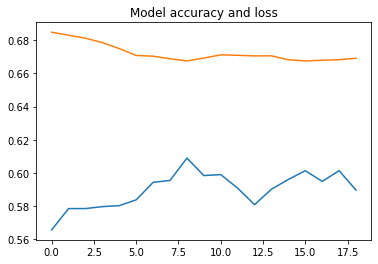

In [238]:
plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
plt.title('Model accuracy and loss')
plt.show()

In [237]:
results = model.evaluate(X_train, y_train, batch_size=256)
print("train loss, train acc:", results)

results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 25ms/step - loss: 0.6669 - acc: 0.6061
train loss, train acc: [0.6669414639472961, 0.6060783267021179]
2/2 [==============================] - 0s 24ms/step - loss: 0.9332 - acc: 0.4933
test loss, test acc: [0.9331575632095337, 0.4933333396911621]


# Summary and closing remarks

Out of the 3 models, the one that simply classified the change of price performed the best.

While neither model was able to achieve a satisfactory performance, the third one was in a relatively unoptimised state able to perform at least somwhat decently, which I find to be a success in confirming that there is possibly potential in this direction.

Another thing I want to briefly touch upon is the training features. Cryptocurrencies are inherently talked about on social media and thus I thought that sentiment would be a possible indicator of the price. The dataset I chose for training was however in my opinion not very well made and this would be one of the first things to optimise if I would want to iterate on this idea in the future. 

Where I think lies the biggest potential however is simply the tweet volume, because the 2 seem to be linked in at least some fashion. While that itself may not be enough to predict the price, it could be a strong indicator.